In [8]:
import xarray as xr
from pathlib import Path
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

import splitting_isca_data as sid

# Import data

In [9]:
path = '/home/links/ct715/data_storage/isca/held-suarez'
exp_list = ['HS_T42_100y_60delh-nc', 'HS_T85_100y_60delh-nc'] # , 'HS_T42_100y_60delh_t42-land-nc'

datasets = {}
for exp in exp_list:
    
    nc_path = Path(path) / exp
    # nc_files = list(nc_path.glob('*.nc'))
    nc_files = nc_path.glob('*.nc')
    
    ds = xr.open_mfdataset(
        nc_files,
        parallel=True,
        chunks={'time': 360}
    )
    
    ds_seasonal = sid.seasonal_mean_datasets(ds)
    datasets[exp] = ds_seasonal

## Subset data

### 24 sets of 33 years

In [10]:
split_3way = {
    'set1': slice('2000-12', '2033-09'),
    'set2': slice('2033-12', '2066-09'),
    'set3': slice('2066-12', '2099-09')
}
split_half = {
    'set1': slice('2000-12', '2049-09'),
    'set2': slice('2049-12', '2098-09')
}
split_full = {
    'set1': slice('2000-12', '2099-09')
}

efp_HS = {}
for key, data in datasets.items():
    
    # split name for var saving
    key_splits = key.split('_')[:2]
    exp_name = f'{key_splits[0]}_{key_splits[1]}'
    
    # calculate EFP for various splits of data
    efp_HS[f'{exp_name}_24sets'] = sid.split_and_process_data(data, split_3way)
    efp_HS[f'{exp_name}_16sets'] = sid.split_and_process_data(data, split_half)
    efp_HS[f'{exp_name}_8sets'] = sid.split_and_process_data(data, split_full)
    


# Seaborn boxplot

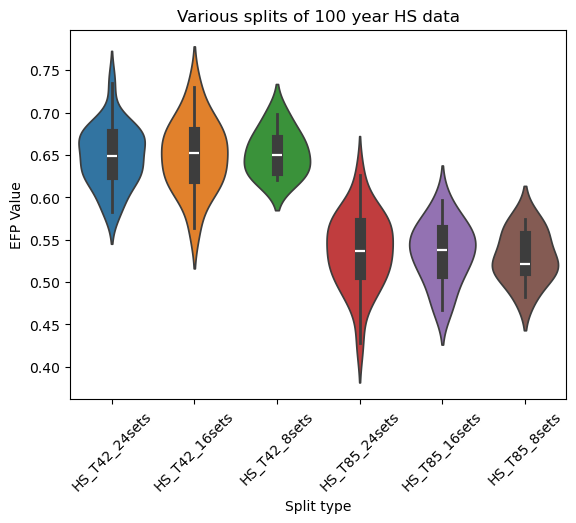

In [11]:
plt.figure()
sns.violinplot(
    data=efp_HS,
    inner_kws=dict(box_width=8, whis_width=2)
)
plt.title('Various splits of 100 year HS data')
plt.xlabel('Split type')
plt.xticks(rotation=45)
plt.ylabel('EFP Value')
plt.show()

***

# Bootstrapping

In [12]:
for key, data in efp_HS.items():
    
    # key_split = key.split('_')
    # exp_name = f'{key_split[0]}_{key_split[1]}'
    # print(exp_name)
    
    print(key)
    sid.print_bootstrap_stats(efp_HS[key])
    print('\n')

HS_T42_24sets
Original Mean: 0.65
Bootstrap Mean: 0.65
95% Confidence Interval: [0.63461615 0.66281667]


HS_T42_16sets
Original Mean: 0.65
Bootstrap Mean: 0.65
95% Confidence Interval: [0.62949281 0.66858828]


HS_T42_8sets
Original Mean: 0.65
Bootstrap Mean: 0.65
95% Confidence Interval: [0.63583719 0.670575  ]


HS_T85_24sets
Original Mean: 0.54
Bootstrap Mean: 0.54
95% Confidence Interval: [0.51921219 0.55376688]


HS_T85_16sets
Original Mean: 0.53
Bootstrap Mean: 0.53
95% Confidence Interval: [0.51752484 0.55116266]


HS_T85_8sets
Original Mean: 0.53
Bootstrap Mean: 0.53
95% Confidence Interval: [0.51075    0.54922531]


